#### Seung Eun YI
#### Student number : 1005078782
##### November 13th, 2018

# Cracking the NYT movie reviews - what you should watch this weekend

*In this report, I look at the relationship between movies, New York Times (NYT) movie critics and Box Office revenue at various degrees, in particular by answering the three general questions written below. The baseline for the data consists of movies from the NYT website of the past 10 years (2008 Jan 1 - 2017 Dec 31). The data used for this report was collected from the NYT website, the OMDb database and the boxoffice package in R.*

## General Questions that the Data Analysis Should Answer:
1. How well do New York Times (NYT) movie critics pick box office hits?

2. Is there a relationship between NYT movie review sentiment and crtics picks?

3. What characteristics of movies affect revenue?

## Table of Contents:
* [Introduction](#first-bullet)
* [Data Collection & Data Cleaning](#second-bullet)
* [Is there a relationship between NYT movie review sentiment and critics picks ?](#third-bullet)
* [How well do New York Times (NYT) movie critics pick box office hits?](#fourth-bullet)
* [What characteristics of movies affect revenue ?](#fifth-bullet)
* [Conclusion](#sixth-bullet)

## Introduction <a class="anchor" id="first-bullet"></a>

With the vast number of new movies at the cinema every week, it has now become difficult to make a quick choice of what to watch. Many resort to movie trailers as well as a variety of reviews on the Internet when choosing a movie to see. Therefore, having good and encouraging reviews is crucial for a movie. 

Measuring a success of a movie can also be an open-ended question. For some movies it could be its profit, for others it could be the reaction of the movie critics or the number of awards that they get at movie festivals. One indicator is its **box office**, a term used to refer to the amount of money raised by ticket values (is the revenue). This interest is often a source of interest for people who want to know how *popular* a movie was, especially for the Hollywood movie industry.

In this report, I analyze movies that were **released in the last 10 years (from January 1st, 2008 to December 31st, 2017)** from diverse points of view. First I specifically look at the movie reviews written by the NYT critics. By analyzing the movie reviews, I especially seek to find out what in the movie review is a sign of critics pick, and I look at the relationship between NYT movie critics pick and box office hits. The first general question is reformulated here, since it is possible to interpret this relationship in two different ways depending on the date the review was written: if the review was written a long time after the movie was released, the relationship looks at whether or not movie critics pick box office hits well; if the review was written shortly after a movie was released, the relationship looks not only at the previous point but also at how it may have positively influenced the public to go to see the movie at the cinema. These two points are very hard to decorrelate. In the last section of the report, I try to identify what movie characteristics might affect the box office revenue, by looking at various features.

Collecting and pre-processing data by cleaning the collected data prior to tackling these questions is central to this problem. Therefore, before analyzing the data and answering the questions, a small section of this report is dedicated to quickly explain what data was collected and how it was cleaned.

## Data Collection & Data Cleaning <a class="anchor" id="second-bullet"></a>

The data that I collected for 10-year-period timeframe comes from:
* Movie Reviews API for NYT movie reviews
* Open Movie Database (OMDb) for box office revenue
* R package "boxoffice" to complete the box office revenue information missing from OMDb

In total, information related to 3941 movies was collected.

For the first two questions, I only needed three features: the movie review, the critics pick (1 if a movie was picked, 0 if it wasn't), and the box office revenue. For these questions, I simply decided to not taking into account movies with missing values. 

For the first question, I therefore worked on **1000 movies**. For the second question and the third questions, I worked on movies where the movie review and the box office revenue are both available, so **430 movies** were chosen and analyzed.

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import scipy.stats
import urllib.request
import seaborn as sns
import time
from textblob import TextBlob
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize
from datetime import timedelta, date
import matplotlib.pyplot as plt

In [2]:
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor

In [3]:
%matplotlib inline

In [4]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [ ]:
# Data Collecting Code:
def get_nyt_data(nyt_api_key, start_date, end_date, offset=0):
    """Gets NYT data using the api key, given a start date and an end date for the opening date
    given a movie."""
    has_more = True
    dfs = []
    while has_more:
        url = ('http://api.nytimes.com/svc/movies/v2/reviews/search.json?opening-date=' + start_date +
                ';' + end_date + '&offset=' + str(offset) + '&api-key=' + nyt_api_key)
        df = pd.read_json(url, orient = 'records')
        if df.empty:
            break
        offset +=20
        has_more = df.tail(1)['has_more'].values[0]
        dfs.append(df)
        time.sleep(0.1)
    nyt = pd.concat(dfs).sort_index()
    return json_normalize(nyt['results'].values)

nyt_api_key = '2bd0cb2ec4e64451883fec67593a0f5c'

df_nyt = get_nyt_data(nyt_api_key, '2008-01-01', '2017-12-31')


def add_movie_reviews(df):
    """Add a movie review column to the input dataframe, by parsing and scraping its content from the
    NYT website."""
    reviews = []
    for i, _ in df.iterrows():
        url = df.loc[i]['link.url']
        page = urllib.request.urlopen(url)
        parse = BeautifulSoup(page, 'html.parser')
        info = parse.find_all('div', attrs={'class': 'StoryBodyCompanionColumn'})
        
        if info == []:
            info = parse.find_all('p', attrs={'class': 'story-body-text story-content'})
        
        info_text = []
        for i in info:
            info_text.append(i.text.strip())
        reviews.append(''.join(info_text))
    reviews = pd.Series(reviews)
    df['movie_review'] = reviews
    return df

def complete_nyt_data(df):
    """Select relevent columns and add movie reviews, to have a first version of the 
    pre-processed dataframe."""
    df = df[['byline', 'critics_pick', 'date_updated', 'display_title', 'headline',
             'link.url', 'opening_date', 'publication_date', 'summary_short']]
    df = add_movie_reviews(df)
    return df

df_nyt = complete_nyt_data(df_nyt)


apikey_omdb = "ab8ac07e"

def get_bo_info(apikey_omdb, df):
    """Get Box Office and supplementary movie information of the movies in the NYT dataframe."""
    df_movies = []
    for i in range(df.shape[0]):
        title = 't=' + df.loc[i]['display_title'].replace(' ', '+')
        req = 'http://www.omdbapi.com/?apikey='+ apikey_omdb + '&'+ title
        try:
            df_movies.append(pd.read_json(req))
        except ValueError:
            continue
        time.sleep(0.1)
    return pd.concat(df_movies).reset_index()

df_omdb = get_bo_info(apikey_omdb, df_nyt)

# Using boxoffice package from R
number_bo = importr("boxoffice")
base = importr('base')

df_bo_r = number_bo.boxoffice(dates=base.seq_Date(base.as_Date('2008-01-01'), base.as_Date('2017-12-31'), 'day'), site = 'numbers')
df_bo_p = pandas2ri.ri2py_dataframe(df_bo_r)

def complete_df_omdb(df, df_from_r):
    """Only keep the relevant columns in the OMDb dataframe, and add box office revenue from the R package."""
    df = df[['Actors', 'BoxOffice', 'Country', 'Director', 'Genre',
             'Language', 'Metascore', 'Plot', 'Rated', 'Production',
             'Ratings', 'Released', 'Runtime', 'Title', 'Writer',
             'Year', 'imdbRating', 'imdbVotes']]
    
    for i in range(df.shape[0]):
        df.at[i, 'Ratings'] = [df.loc[i]['Ratings']]
    
    df['Rating_sum'] = df.groupby('Title')['Ratings'].transform('sum')
    df_omdb_f = df.drop_duplicates(subset=['Title'])
    
    df_from_r = df_from_r.sort_values('days', ascending=False).drop_duplicates(['movie'])
    
    #Transforming the titles to get more matching results
    df_omdb_f['title_2'] = df_omdb_f['Title'].str.lower().replace(" ", "")
    df_from_r['title_2'] = df_from_r['movie'].str.lower().replace(" ", "")
    
    df_merged = pd.merge(df_omdb_f, df_from_r ,how='left', left_on=['title_2'], right_on=['title_2'])
    return df_merged

df_bo_complete = complete_df_omdb(df_omdb, df_bo_p)

df_complete = pd.merge(df_nyt, df_bo_complete,how='left', left_on=['display_title'], right_on=['Title'])

In [1]:
# Data Cleaning Code:
df = pd.read_csv('https://raw.githubusercontent.com/se-yi/STA2453/final_report/df_complete.csv')

df = df[['opening_date', 'Title', 'Actors', 'Country', 'Director',
         'Genre', 'Language', 'Metascore', 'Runtime', 'Writer', 'Year',
         'imdbRating', 'imdbVotes', 'Rating_sum',
         'date_updated', 'byline', 'headline', 'movie_review','critics_pick',
         'BoxOffice', 'total_gross'
        ]]

#Renaming columns
df = df.rename(columns={'opening_date': 'Opening_date', 'byline': 'Critic_name',
                        'date_updated': 'Review_date', 'headline': 'Headline',
                        'movie_review': 'Movie_review', 'critics_pick': 'Critics_pick',
                        'BoxOffice': 'Omdb_revenue', 'total_gross': 'Bo_revenue'})

#Defining holiday_season
summer_start = date(2000, 6, 15)
summer_end = date(2000, 8, 31)
winter_start = date(2000, 12, 1)
winter_end = date(2000, 12, 31)
winter2_start = date(2000, 1, 1)
winter2_end = date(2000, 1,15)

Holiday = []
for i, r in df.iterrows():
    month, day = r['Opening_date'][5:7], r['Opening_date'][8:10]
    date_r = date(2000, int(month), int(day))
    if ((summer_start < date_r < summer_end) | (winter_start < date_r < winter_end) | (winter2_start < date_r < winter2_end)):
        Holiday.append(1)
    else:
        Holiday.append(0)
        
df['Holiday'] = Holiday

#Cleaning Runtime variable
for i, r in df.iterrows():
    try:
        df.at[i, 'Runtime'] = float(df.at[i, 'Runtime'][:-4])
    except:
        df.at[i, 'Runtime'] = np.nan
        
#Cleaning Rating sum variable into the Rotten Tomatoes rating
for i, r in df.iterrows():
    try:
        df.at[i, 'Rating_sum'] = float(df.at[i, 'Rating_sum'].split('\'Rotten Tomatoes\', \'Value\': \'')[1][:2])
    except:
        df.at[i, 'Rating_sum'] = np.nan

df_cleaned = df.rename(columns={'Rating_sum': 'Rotten_tomatoes'})

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/se-yi/STA2453/final_report/df_cleaned.csv')

## Is there a relationship between NYT movie review sentiment and critics picks ? <a class="anchor" id="third-bullet"></a>

In [30]:
df_sentiment = df[df['Movie_review'].isnull() == False][['Title','Critic_name','Movie_review', 'Critics_pick']]

Critics pick a movie for different reasons, and this can depend on the critics' personal preference. In this part, I look at different sentiments in a movie review that might lead a critic to pick the movie. Here, 1000 movies were analyzed. I used the **TextBlob library** specialized in NLP in Python, that can analyze "sentiments" in a given text and output two values: **polarity (positive or negative)** and **subjectivity (subjective or objective)**.

As an example, let's look at one example of movie review and extract its polarity and subjectivity using Textblob:

*“Into the Woods,” the splendid Disney screen adaptation of the Stephen Sondheim-James Lapine musical, infuses new vitality into the tired marketing concept of entertainment for “children of all ages.” That usually translates to mean only children and their doting parents. But with “Into the Woods,” you grow up with the characters, young and old, in a lifelong process of self-discovery.Directed by Rob Marshall (“Chicago,” “Nine”), this witty and touching mash-up of several Grimm fairy tales is viewed through a post-Freudian prism."*

This is a review of the movie "Into the Woods", picked by the critic Stephen Holden.

Using the TextBlob library, an analysis of this review gives the following sentiment: **Sentiment(polarity=0.08516899766899767, subjectivity=0.5224650349650349)**

As we can see, the positive polarity implies that the critic gave a positive review, which is also indicated by expression such as *"splendid ... adaptation"*, *"new vitality into the tired marketing concept of entertainment for ...*, or *"this witty and touching"*. The subjectivity that is slightly higher than *0.5* implies that this review is more likely to be a subjective review than an objective one, which is the case.

We can now look at the general polarity and subjectivity for all the movie reviews we are analyzing. We want to compare how they are distributed for the movies that were not chosen by the critics and those that were chosen by the critics.

**Out of 1000 movies, there are 184 movies that were picked by the critics, and 816 movies that were not chosen by the critics.**

In [31]:
def sentiment_average(df):
    """Analyzes the sentiment for each movie review, for a given dataframe."""
    polarity = []
    subjectivity = []
    for i, r in df.iterrows():
        review = TextBlob(r['Movie_review'])
        polarity.append(review.sentiment.polarity)
        subjectivity.append(review.sentiment.subjectivity)
    
    df['Polarity'] = polarity
    df['Subjectivity'] = subjectivity
    
    return df, np.mean(polarity), np.mean(subjectivity), polarity, subjectivity

In [32]:
df_picked_1 = df_sentiment[df_sentiment['Critics_pick'] == 1]
df_picked_0 = df_sentiment[df_sentiment['Critics_pick'] == 0]

In [33]:
df_picked_1, polarity_cp, subjectivity_cp, list_polarity_cp, list_subjectivity_cp = sentiment_average(df_picked_1)

In [34]:
df_picked_0, polarity_ncp, subjectivity_ncp, list_polarity_ncp, list_subjectivity_ncp = sentiment_average(df_picked_0)

In [35]:
df_sentiment, _, _, _, _ = sentiment_average(df_sentiment)

The normalized distribution of polarity and subjectivity for movies that were picked by critics and those that were not picked is as the following:

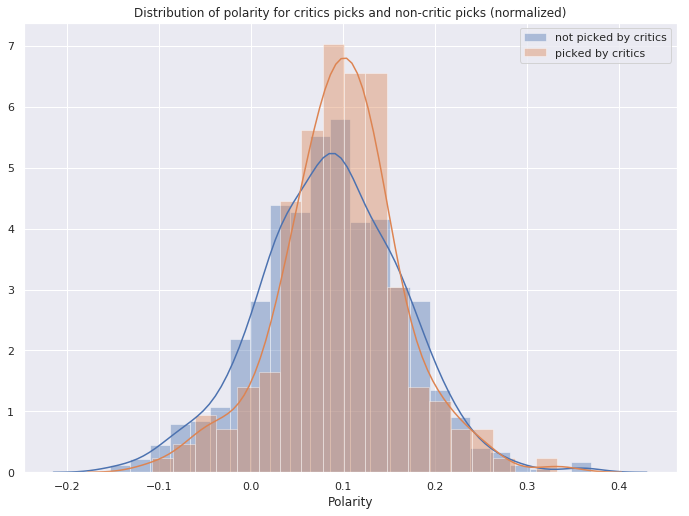

In [36]:
sns.distplot(df_picked_0[('Polarity')], label='not picked by critics')
sns.distplot(df_picked_1[('Polarity')], label='picked by critics')
plt.title('Distribution of polarity for critics picks and non-critic picks (normalized)')
plt.legend()

Text(0.5, 1.0, 'Distribution of polarity for critics picks and non-critic picks (boxplot)')

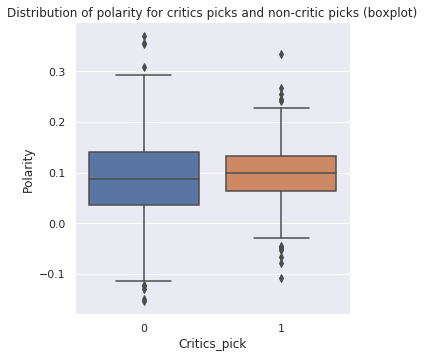

In [37]:
sns.catplot(x='Critics_pick', y='Polarity', kind='box', data=df_sentiment)
plt.title('Distribution of polarity for critics picks and non-critic picks (boxplot)')

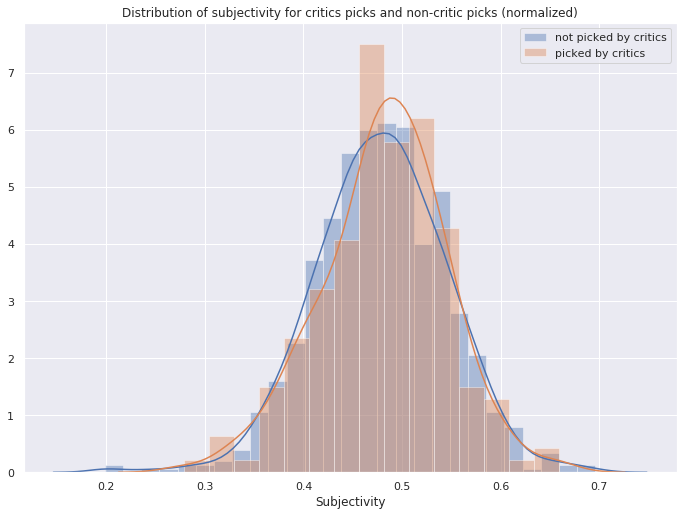

In [28]:
sns.distplot(df_picked_0[('Subjectivity')], label='not picked by critics')
sns.distplot(df_picked_1[('Subjectivity')], label='picked by critics')
plt.title('Distribution of subjectivity for critics picks and non-critic picks (normalized)')
plt.legend()

Text(0.5, 1.0, 'Distribution of subjectivity for critics picks and non-critic picks (boxplot)')

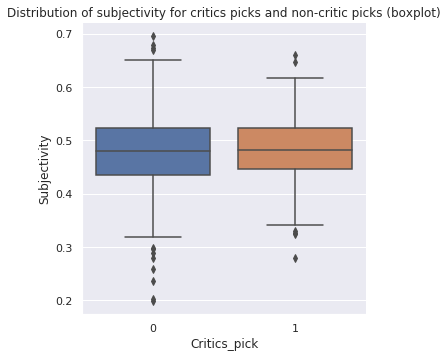

In [38]:
sns.catplot(x='Critics_pick', y='Subjectivity', kind='box', data=df_sentiment)
plt.title('Distribution of subjectivity for critics picks and non-critic picks (boxplot)')

In [39]:
print('Average polarity for the movies picked by the critics is:' + str(polarity_cp))
print('Average polarity for the movies not picked by the critics is:' + str(polarity_ncp))

Average polarity for the movies picked by the critics is:0.09762871117767766
Average polarity for the movies not picked by the critics is:0.08662508383918738


In [40]:
print('Average subjectivity for the movies picked by the critics is:' + str(subjectivity_cp))
print('Average subjectivity for the movies not picked by the critics is:' + str(subjectivity_ncp))

Average subjectivity for the movies picked by the critics is:0.48151894995868066
Average subjectivity for the movies not picked by the critics is:0.47826530218894797


It seems as if the movies picked by the critics have slightly more positive, and more subjective reviews. However, this difference is not very obvious. I decided to conduct a T-test to see if the difference in average polarity and subjectivity between the movies picked by the critics and not picked by the critics can be considered significant. A T-test gives the following results:

In [41]:
t_polarity, p_polarity = scipy.stats.ttest_ind(list_polarity_cp, list_polarity_ncp)

In [42]:
print('t statistic for the polarity mean difference: ' + str(t_polarity))
print('p-value for the polarity mean difference: ' + str(p_polarity))

t statistic for the polarity mean difference: 1.7745001192554986
p-value for the polarity mean difference: 0.07628526093501731


In [43]:
t_subjectivity, p_subjectivity = scipy.stats.ttest_ind(list_subjectivity_cp, list_subjectivity_ncp)

In [44]:
print('t statistic for the subjectivity mean difference: ' + str(t_subjectivity))
print('p-value for the subjectivity mean difference: ' + str(p_subjectivity))

t statistic for the subjectivity mean difference: 0.6031238960797504
p-value for the subjectivity mean difference: 0.5465633051900582


**Therefore, the difference in polarity between the different types of movies seems to be quite significant (at a 10% significant level).** The difference in subjectivity is not significant.

The significant difference in polarity implies that the sentiments in the NYT movie reviews are a possible indicator of if the critics will pick a given movie or not. If a movie review is positive, then it is more likely to be picked by critics, which seems to be logical.

## How well do New York Times (NYT) movie critics pick box office hits? <a class="anchor" id="fourth-bullet"></a>

For this question, I will look at the dataset without missing information. As briefly explained in the introduction, this question depends on dates the movie reviews were written. If the movie reviews are written right after the movie is out, then it might affect people's decisions and this might result in a higher (or lower if the review is very negative) box office revenue, and it is hard to see in what way one influences another. Here, the review date was not precise enough (except for certain movie, the website might have been redone, since all the dates were from November 2017). Therefore, I could not use this data.

Since there were a lot of values missing from the OMDb website but present in the Numbers data and vice-versa, I first thought of combining the two sets of values to have fewer missing values. However, I finally decided to not combine these since I did not think of them as feasible (no idea of how they were really collected, there are some very big differences between both values, so it was too risky - I present it briefly in my presentation). Therefore I look at 337 movies that were not picked by the critics and 83 that were picked by the critics.

In [54]:
df_q2 = df[(df['Bo_revenue'].isnull() == False) & (df['Movie_review'].isnull()==False)]

In [55]:
df_picked_1_q2 = df_q2[df_q2['Critics_pick'] == 1]
df_picked_0_q2 = df_q2[df_q2['Critics_pick'] == 0]

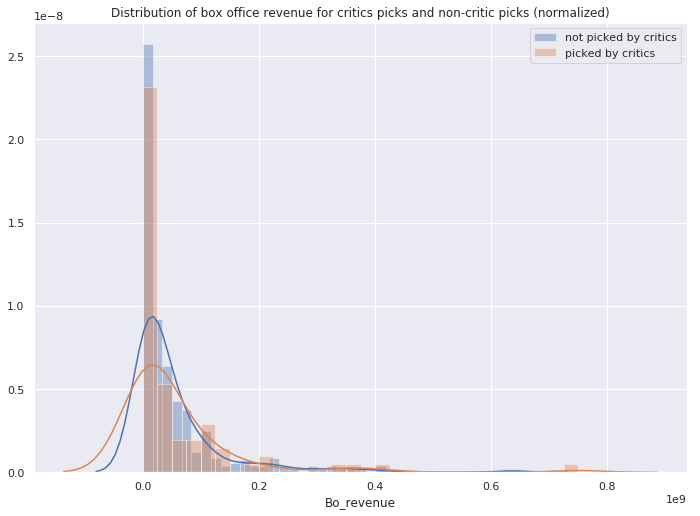

In [56]:
sns.distplot(df_picked_0_q2[('Bo_revenue')], label='not picked by critics')
sns.distplot(df_picked_1_q2[('Bo_revenue')], label='picked by critics')
plt.title('Distribution of box office revenue for critics picks and non-critic picks (normalized)')
plt.legend()

Text(0.5, 1.0, 'Distribution of box office revenue for critics picks and non-critic picks (boxplot)')

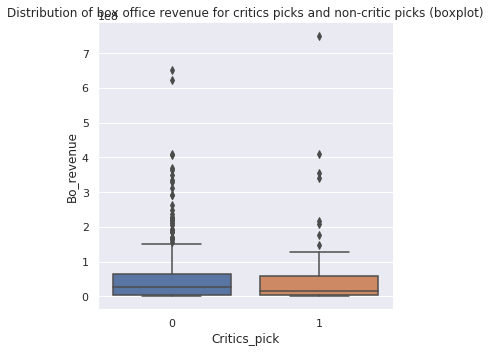

In [57]:
sns.catplot(x='Critics_pick', y='Bo_revenue', kind='box', data=df_q2)
plt.title('Distribution of box office revenue for critics picks and non-critic picks (boxplot)')

In [58]:
print('Median box office revenue for the movies picked by the critics is: ' + str(np.median(df_picked_1_q2['Bo_revenue'])))
print('Median box office revenue for the movies not picked by the critics is: ' + str(np.median(df_picked_0_q2['Bo_revenue'])))

Median box office revenue for the movies picked by the critics is: 16022451.0
Median box office revenue for the movies not picked by the critics is: 25584504.0


In [59]:
print('Average box office revenue for the movies picked by the critics is: ' + str(np.mean(df_picked_1_q2['Bo_revenue'])))
print('Average box office revenue for the movies not picked by the critics is: ' + str(np.mean(df_picked_0_q2['Bo_revenue'])))

Average box office revenue for the movies picked by the critics is: 57360297.313253015
Average box office revenue for the movies not picked by the critics is: 53511972.22255193


As in the previous question, I conducted a T-test to see how significant the difference in average box office revenue for critics picks and non-critics picks is.

In [60]:
t_bo, p_bo = scipy.stats.ttest_ind(df_picked_1_q2['Bo_revenue'], df_picked_0_q2['Bo_revenue'])

In [61]:
print('t statistic for the box office revenue mean difference: ' + str(t_bo))
print('p-value for the box office revenue mean difference: ' + str(p_bo))

t statistic for the box office revenue mean difference: 0.34347592845048674
p-value for the box office revenue mean difference: 0.7314131385701134


When looking at the boxplot, there seemed to be a significant difference between the median box office revenue for the movies picked by the critics (16m dollars) and not picked by the critics (26m dollars). Therefore, **I decided to conduct a Kruskal-Wallis test to see if this difference is important**. This test allows us to compare medians of two different populations and gives an idea of how the difference can be considered important.

In [62]:
h_k_bo, p_k_bo = scipy.stats.kruskal(df_picked_1_q2['Bo_revenue'], df_picked_0_q2['Bo_revenue'])

In [63]:
print('t statistic for the box office revenue median difference: ' + str(h_k_bo))
print('p-value for the box office revenue median difference: ' + str(p_k_bo))

t statistic for the box office revenue median difference: 0.6961085100532362
p-value for the box office revenue median difference: 0.40409438887727966


Here, I therefore found out that the p-values obtained after these two tests were both very high, therefore not being very significant. **The movies picked by the critics do not necessarily reflect if the revenue would be high or not.** I would therefore say that the NYT critics do not necessarily pick box office hits.

## What characteristics of movies affect revenue ? <a class="anchor" id="fifth-bullet"></a>

To answer this question, I selected a variety of features that could give insights on what characteristics of movies could influence the box office revenue the most. These include:
* **Ratings** (from 3 different sources, Metascore, Rotten Tomatoes and IMDb)
* **IMDb votes** (number of voters, reflects popularity of the movie)
* **Runtime** (length of the movie)
* **Holiday season** (Christmas season, Summer vacation seasons... Seasons targeted by movies to have more viewers)
* **Country** (I thought this can be an interesting feature since different countries often have different "styles" of movies and it could influence the moviegoers' decisions
* **Genre** (big blockbusters are often action movies)

In [66]:
df = df[(df['Bo_revenue'].isnull() == False) & (df['Movie_review'].isnull()==False)]

Here are some plots of relationship between variables above and the box office revenue.

Text(0.5, 1.0, 'Relationship between Metascore and Box office revenue')

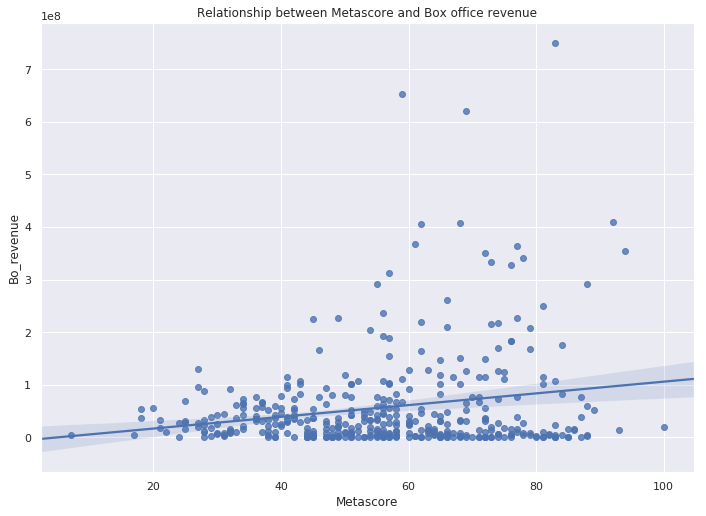

In [67]:
ax = sns.regplot(x='Metascore', y='Bo_revenue', data=df)
plt.title('Relationship between Metascore and Box office revenue')

Text(0.5, 1.0, 'Relationship between Runtime and Box office revenue')

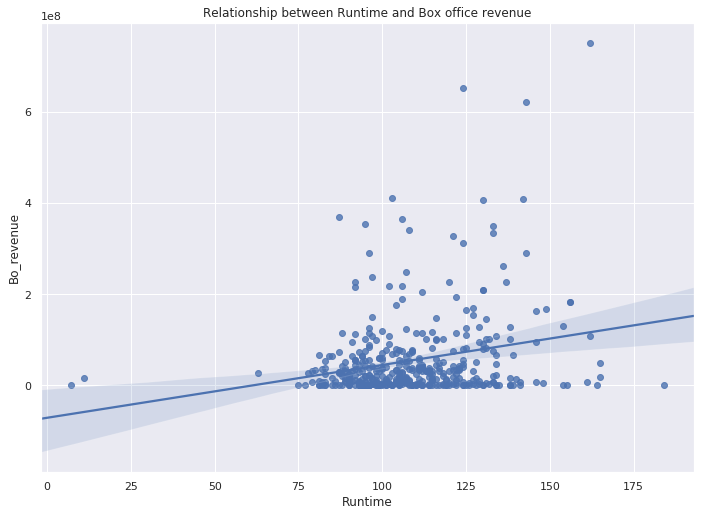

In [68]:
ax = sns.regplot(x='Runtime', y='Bo_revenue', data=df)
plt.title('Relationship between Runtime and Box office revenue')

Text(0.5, 1.0, 'Relationship between imdbRating and Box office revenue')

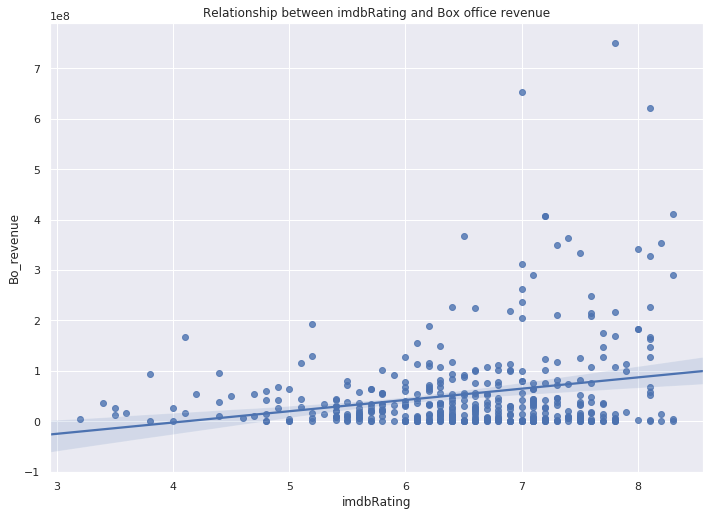

In [69]:
ax = sns.regplot(x='imdbRating', y='Bo_revenue', data=df)
plt.title('Relationship between imdbRating and Box office revenue')

Text(0.5, 1.0, 'Relationship between imdbVotes and Box office revenue')

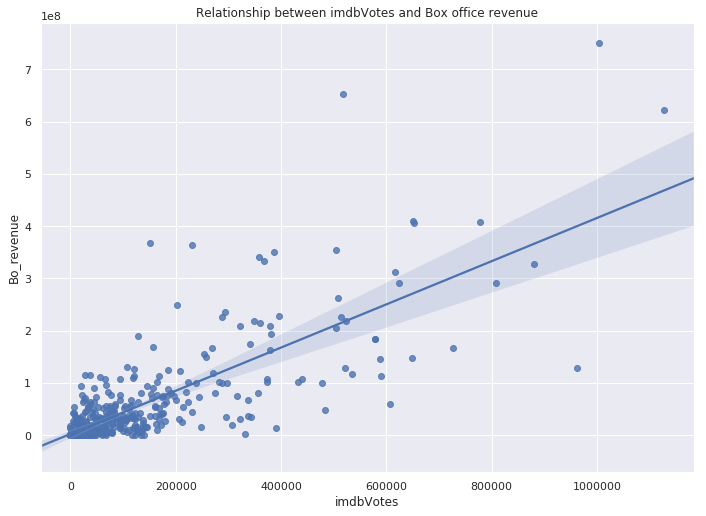

In [70]:
ax = sns.regplot(x='imdbVotes', y='Bo_revenue', data=df)
plt.title('Relationship between imdbVotes and Box office revenue')

Text(0.5, 1.0, 'Relationship between Rotten_tomatoes and Box office revenue')

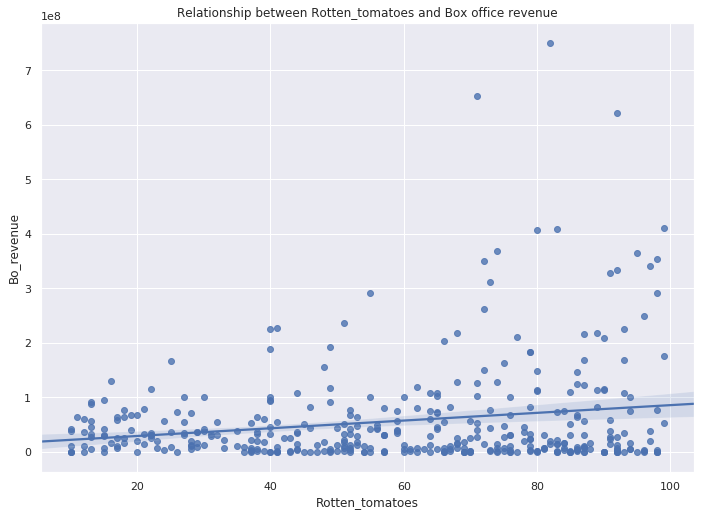

In [71]:
ax = sns.regplot(x='Rotten_tomatoes', y='Bo_revenue', data=df)
plt.title('Relationship between Rotten_tomatoes and Box office revenue')

Text(0.5, 1.0, 'Relationship between Holiday and Box office revenue')

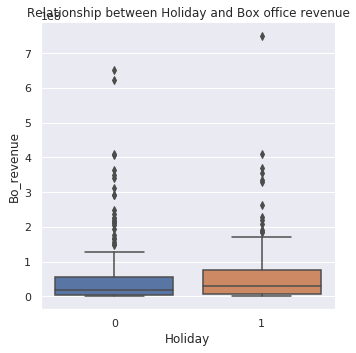

In [72]:
ax = sns.catplot(x='Holiday', y='Bo_revenue', kind='box', data=df)
plt.title('Relationship between Holiday and Box office revenue')

The next thing I did, for *country* and *genre* variables, is that I dummified these variables: I got around 70 different countries and 30 different genres.

In [73]:
df = pd.concat([df, df['Country'].str.get_dummies(sep=','),
                        df['Genre'].str.get_dummies(sep=','),
                       ], axis=1)

In [74]:
df_to_fit = df.drop(['Year', 'Country', 'Genre', 'Writer',
                  'Opening_date', 'Title', 'Actors', 'Director', 'Language',
                  'Review_date', 'Critic_name', 'Headline', 'Movie_review',
                  'Omdb_revenue', 'Unnamed: 0'], axis=1).reset_index(drop=True)

In [75]:
df_to_fit.dropna(inplace=True)

The final dataset looks like this:

In [76]:
df_to_fit.head(3)

,Metascore,Runtime,imdbRating,imdbVotes,Rotten_tomatoes,Critics_pick,Bo_revenue,Holiday,Australia,Austria,...,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Music,Mystery,Sci-Fi,Short
0,49.0,102.0,6.4,32024.0,48.0,0,1951776.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,40.0,105.0,5.4,50176.0,20.0,0,20527175.0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,42.0,112.0,5.2,7530.0,41.0,0,17472.0,1,1,0,...,0,0,0,1,0,0,0,0,0,0


I also thought it would be interesting to look at the correlation between various variables and represent it with the heatmap : **this helped me to visualize, along with the scatterplots, that the popularity and the ratings might have the strongest relationships with the final box office revenue.**

Text(0.5, 1.0, 'Heatmap looking at the correlation between different variables')

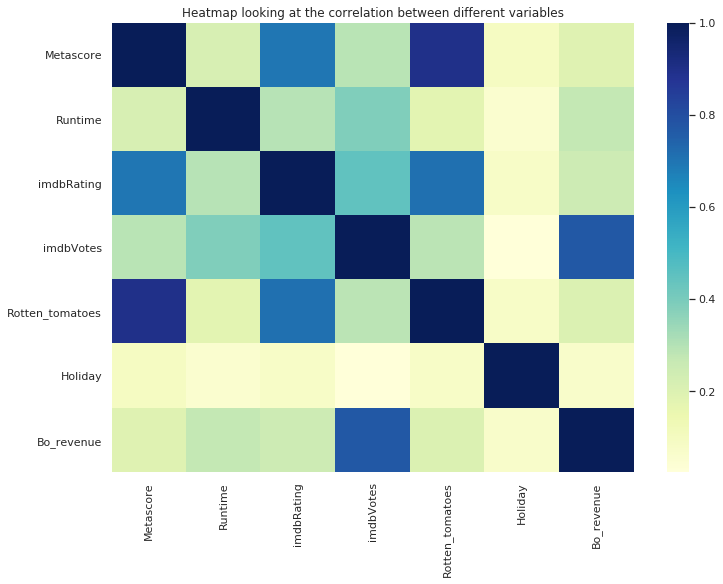

In [78]:
sns.heatmap(df_to_fit[['Metascore', 'Runtime', 'imdbRating', 'imdbVotes',
                       'Rotten_tomatoes', 'Holiday', 'Bo_revenue']].corr(), cmap="YlGnBu")
plt.title('Heatmap looking at the correlation between different variables')

In [80]:
# The final datasets
X = df_to_fit.drop(['Bo_revenue'], axis=1)
y = df_to_fit['Bo_revenue']

I first fitted a linear regression model after normalizing the features' values.

In [81]:
lr = LinearRegression(normalize=True)

In [82]:
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

However, I realized that due to the sparsity of the variables (especially country / genre variables), the coefficients' values were very sensitive to individual point : for example, if there is only one movie from the Czech Republic in the dataset and it brought a big success, this model would recognize the Czech Republic as a very important factor determining the box office revenue. Some of the coefficient values are as following:

In [85]:
lr.coef_[:10]

array([-4.07929486e+05,  2.23424673e+05, -2.33867421e+07,  4.42026114e+02,
        4.76521969e+05, -2.71418219e+05,  1.43223633e+07, -1.98580761e+07,
        2.49878586e+07, -2.77476385e+07])

Looking at the features that have the highest coefficients (in absolute values) shows that effectively, surprising features are considered as having the biggest weights:

In [87]:
feat_imp = pd.DataFrame({'importance':np.abs(lr.coef_)})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:20]

feat_imp.sort_values(by='importance', inplace=True)
#feat_imp = feat_imp.set_index('feature', drop=True)

Text(0.5, 1.0, 'Feature Importance for a Linear Regression Model')

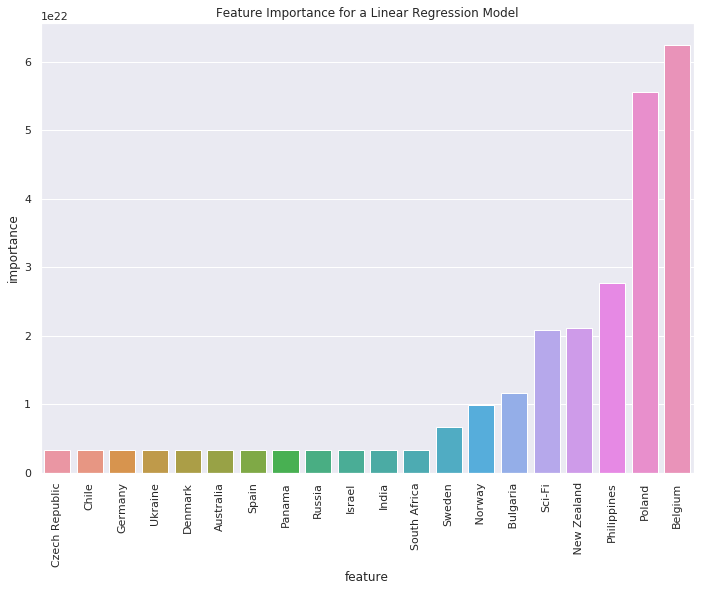

In [89]:
features = sns.barplot(x='feature', y='importance',data=feat_imp)
features.set_xticklabels(features.get_xticklabels(), rotation=90)
plt.title('Feature Importance for a Linear Regression Model')

The coefficient of determination of this model is around **0.75:**

In [94]:
lr.score(X,y)

0.7484047970029157

This is why I decided to look at **decision tree models, since they are more robust to sparse variables and they are able to pick well the important variables at the beginning to split nodes**. Since I have a fairly small dataset, I restricted the max depth of the tree to 5.

In [108]:
dt = DecisionTreeRegressor(max_depth=5)

In [109]:
dt.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Looking at the features that have the highest coefficients (in absolute values) gives the following graph:

In [110]:
feat_imp = pd.DataFrame({'importance':dt.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:20]

feat_imp.sort_values(by='importance', inplace=True)

Text(0.5, 1.0, 'Feature Importance Score')

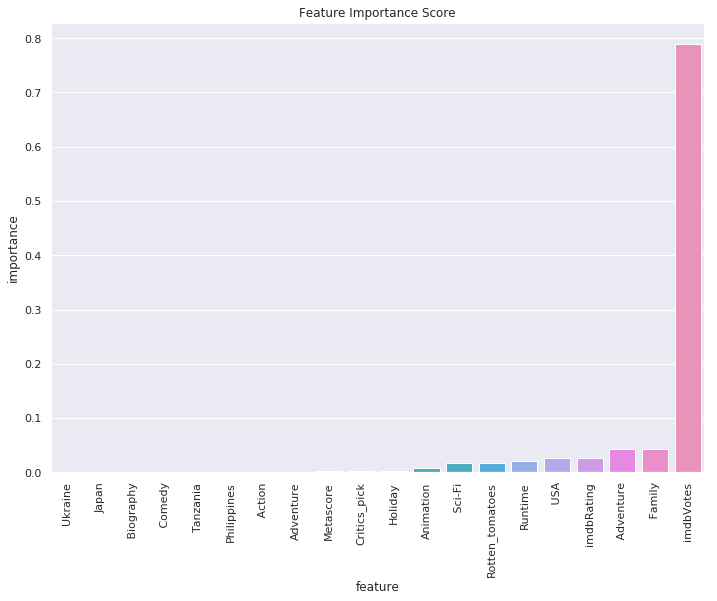

In [111]:
features = sns.barplot(x='feature', y='importance',data=feat_imp)
features.set_xticklabels(features.get_xticklabels(), rotation=90)
plt.title('Feature Importance Score')

The **imdbVotes (that can be interpreted as the popularity)**, as shown in the previous visualizations, are very important in determining the box office revenue of a movie, and seems reasonable. Then, the **genres (Family movies / Adventure movies)** and the **ratings have an influence**; as well as the **USA feature**. This could be because family genre is one of the preferred movie genres to target all the audience and the adventure genre is the common genre to all the blockbusters. The ratings are also an important characteristic for the movies.

The accuracy score is around **85%**.

In [105]:
dt.score(X,y)

0.8486946925983897

In [107]:
with open("dt_regressor.txt", "w") as f:
    f = export_graphviz(dt, out_file=f, feature_names=X.columns)

## Conclusion <a class="anchor" id="sixth-bullet"></a>

In conclusion, the analyses made on the NYT movie reviews and different characteristics of a movie brought interesting insights on what makes a successful movie.
* **The NYT movie review sentiments are an indicator of the critics picks**: positive reviews imply higher chance of the critics picking the movie.
* However, **the critics do not necessarily pick box office revenues well**.
* Characteristics such as the **imdbVotes, certain genres (family, action), movie ratings (imdB ratings, Rotten Tomatoes)** seem to influence the box office revenue.

##### Challenges and limitations vs. What I enjoyed
What made the project very difficult was collecting the right data. OMDb has a limited amount of queries per day, and when calling the API we have a query number limit per second. Moreover, I had difficulties scraping data from the Mojo website, so I had to import R packages and use R library on Python - I would have liked to be more comfortable when handling data scraped from the internet. Since there were a lot of missing values, I always had less data then I had expected and I had to keep repeating the same steps for data collection several times. Joining the dataframes was another problem, since different sources had different values for box office revenue or different ways of writing the movie names, so extra work was needed to try to merge them correctly and deal with how to combine values for the same variable, but from different sources.

I think it is the step that took at least one third or more time when I worked on the project. With the missing values, I think my data might have been biased (more famous movies - so with higher box office revenue would have more information, so less likely to be missing) and might not have been representative of the whole movie population.

On the other hand, the questions for this project were very open and allowed me to come up with a lot of subquestions that helped me structure and answer them in an organized way. I really enjoyed having my freedom to explore the datasets and come up with my own solutions. Having an open-ended questions also challenged me and helped me into creating my own variables (such as the Holiday variable), or making a variety of visualizations to help me get more insights and think of what to focus on.

##### Future works
* I would have liked to collect more data to have more than 1000 movies' informations for the last two questions. I would be more aware of the proportion of missing values, and collect always more than what I think I need, so that I don't have to collect data several times.
* I would have liked to work more on the features of the movies. In particular, I would have liked to work on director and actors, since they are very important features for me. One way of exploring it could be treating them as categorical variables but that would imply to many features; I could have looked at their popularity and give corresponding weights to the actors and the director related to each movie. I would also go look for other variables (the budget that can be an important indicator, or the number of screens that played the films).
* I would elaborate more on how to deal with the box office revenue as a measure of success of a movie - it is one of the commonly used metric, but I should think more of how this might be biased since it only reflects the revenue and not the profit. Moreover, the ticket price varies throughout different cities and countries - in New York, the tickets are almost as twice as higher as the tickets' prices in other cities, meaning that if there is a movie (ie. on New York) that people from New York like, the movie might have a higher box office revenue than another movie at the end, even though the latter might have had more audience in terms of their number. The changing monetary value is another challenge that is added to this problem, so I could have tried to adjust the revenue value for different time periods.

##### Insights
* I realized again that data collection and preprocessing data is one of the most (or sometimes "the" most) important parts when doing data analysis. Clean and appropriate data is crucial to meaningful and accurate analysis.
* Statistical communication can be challenging , I always tried to look at the problem from a non-technical point of view, to keep in mind what results I am looking for, what concrete interpretations and conclusions I should be giving with each result and how to explain without statistical jargons. Communication is an essential part in data science.
* During the projects, I tried to come up with a variety of statistical methods, and I learned that a good way is to start with simple methods. Even though I do not use very complicated methods, simple visualizations can help me get a first insight on the problem and figure out how I am going to tackle the problem.
* With each assignment and project, I learned that what I am seeing is not all
* At the beginning of the course, each time we had an assignment to hand in and to present, I thought that it might not be interesting by the end since we would all be presenting the same content. However, I realized (for example from the presentation on the temperature difference between Toronto and Thunderbay) how a same problem can yield very different answers. It really depends on what we decide to focus on, what we want to learn from the problem, and what methods we use. Every time, I realized that what I am seeing is not all, and for one simple question there always can be a variety of different and insightful answers. It was a very interesting lesson for me, and now I no longer consider statistical work as a mathematical work that has one unique and right answer, but as something very flexible and open-ended. 


*Some webpages I consulted to find out more about moviegoers and movies:*
* https://www.slashfilm.com/google-is-able-to-predict-box-office-with-94-accuracy/
* https://entertainment.howstuffworks.com/movie-box-office3.htm

In [112]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')